# Project 8
### Try Detectron 2

Check the version of CUDA

In [19]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Aug_20_13:58:20_Pacific_Daylight_Time_2025
Cuda compilation tools, release 13.0, V13.0.88
Build cuda_13.0.r13.0/compiler.36424714_0


Install peered torch version

In [20]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126


Looking in indexes: https://download.pytorch.org/whl/cu126


Install Detectron 2

In [1]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
try:
    dist = distutils.core.run_setup("./detectron2/setup.py")   
    # !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
    sys.path.insert(0, os.path.abspath('./detectron2'))
except Exception as e:
    print('Exception',e)
# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

torch:  2.9 ; cuda:  cu126
True
1


In [3]:
import os
import numpy as np
import json
import pandas as pd
from detectron2.structures import BoxMode
import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available, using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available, using CPU.")

Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
NumExpr defaulting to 16 threads.
torch:  2.9 ; cuda:  cu126
True
1
CUDA is available, using GPU.


In [4]:
def get_cat_dict(directory,jsonfile_name):
    classes = ['Khawlahm','Khawniewping','Khawtang']
    dataset_dicts = []
    json_file = os.path.join(directory,jsonfile_name)
    try:
        with open(json_file) as f:
            json_ann_file = json.load(f)
    except FileNotFoundError:
        print('File is not exist, if this is the test dataset, you can ignore')
        return {}
        
    image_list = json_ann_file['images']
    annotation_list = pd.DataFrame(json_ann_file['annotations'])
    
    for image in image_list :
        record = {}
        filename = os.path.join(directory,image['file_name'])

        record['file_name'] = filename
        record['height'] = image['height']
        record['width'] = image['width']
        image_id = image['id']

        # find the annotation of this image
        annos = annotation_list[annotation_list['image_id'] == image_id]
        objs = []
        for idx,anno in  annos.iterrows() :
            obj = {
                "bbox":anno['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation":anno['segmentation'],
                "category_id":anno['category_id'],
                'iscrowd':0
            }
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)

    return dataset_dicts
    

Register Data Catalog

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("cat_" + d, lambda d=d: get_cat_dict(f'cat-dataset/{d}','result.json'))
    MetadataCatalog.get("cat_" + d).set(thing_classes=['Khawlahm','Khawniewping','Khawtang'])

In [6]:
cat_metadata = MetadataCatalog.get("cat_train")

### Training The Model
Setting the config and create trainer based on default trainer

In [7]:
# Check if CUDA is available
print(f"Is CUDA available? {torch.cuda.is_available()}")

Is CUDA available? True


In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('cat_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

d:\tin\basic-image\detectron2\detectron2\model_zoo\model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)


In [10]:
trainer = DefaultTrainer(cfg)


Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): Bottlene

SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


In [11]:
trainer.resume_or_load(resume=False)

[DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
URL https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl cached in C:\Users\theet/.torch/iopath_cache\detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600\model_final_f10217.pkl
[Checkpointer] Loading from C:\Users\theet/.torch/iopath_cache\detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600\model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

Train the model

In [12]:
trainer.train()

Starting training from iteration 0


c:\Users\theet\anaconda3\envs\detectron2\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
W1031 10:33:48.854000 3876 site-packages\torch\fx\_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


 eta: 0:02:38  iter: 19  total_loss: 2.32  loss_cls: 1.449  loss_box_reg: 0.1708  loss_mask: 0.6917  loss_rpn_cls: 0.004305  loss_rpn_loc: 0.003665    time: 0.1769  last_time: 0.1458  data_time: 0.1545  last_data_time: 0.0009   lr: 4.9953e-06  max_mem: 1976M
 eta: 0:02:28  iter: 39  total_loss: 2.154  loss_cls: 1.285  loss_box_reg: 0.1555  loss_mask: 0.6831  loss_rpn_cls: 0.002457  loss_rpn_loc: 0.003307    time: 0.1603  last_time: 0.1496  data_time: 0.0012  last_data_time: 0.0012   lr: 9.9902e-06  max_mem: 1976M
 eta: 0:02:22  iter: 59  total_loss: 1.827  loss_cls: 0.9697  loss_box_reg: 0.1861  loss_mask: 0.6674  loss_rpn_cls: 0.003124  loss_rpn_loc: 0.004563    time: 0.1563  last_time: 0.1506  data_time: 0.0018  last_data_time: 0.0013   lr: 1.4985e-05  max_mem: 1976M
 eta: 0:02:19  iter: 79  total_loss: 1.477  loss_cls: 0.6634  loss_box_reg: 0.171  loss_mask: 0.6427  loss_rpn_cls: 0.005646  loss_rpn_loc: 0.005405    time: 0.1553  last_time: 0.2510  data_time: 0.0079  last_data_time: 

## Inference from the model
Before Inference of Testing, we will get the model which is store in the file to keep in a variable.

In [13]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("cat_test", )
predictor = DefaultPredictor(cfg)

[DetectionCheckpointer] Loading from ./output\model_final.pth ...
[Checkpointer] Loading from ./output\model_final.pth ...


Try to Inference by try to get some of image from testing data

In [14]:
test_image_list = os.listdir('cat-dataset/test')
top_3_images = pd.Series(test_image_list)
top_3_images = top_3_images.sample(5)

Import the library which is required for the visualization

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [16]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

import cv2
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Tahoma'
plt.rcParams['font.size'] = 12


matplotlib data path: c:\Users\theet\anaconda3\envs\detectron2\Lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\theet\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\theet\.matplotlib
Using fontManager instance from C:\Users\theet\.matplotlib\fontlist-v390.json


findfont: Matching Tahoma:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='c:\\Users\\theet\\anaconda3\\envs\\detectron2\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\theet\\anaconda3\\envs\\detectron2\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\theet\\anaconda3\\envs\\detectron2\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\theet\\anaconda3\\envs\\detectron2\\Lib\\site-packages\\matplotlib\

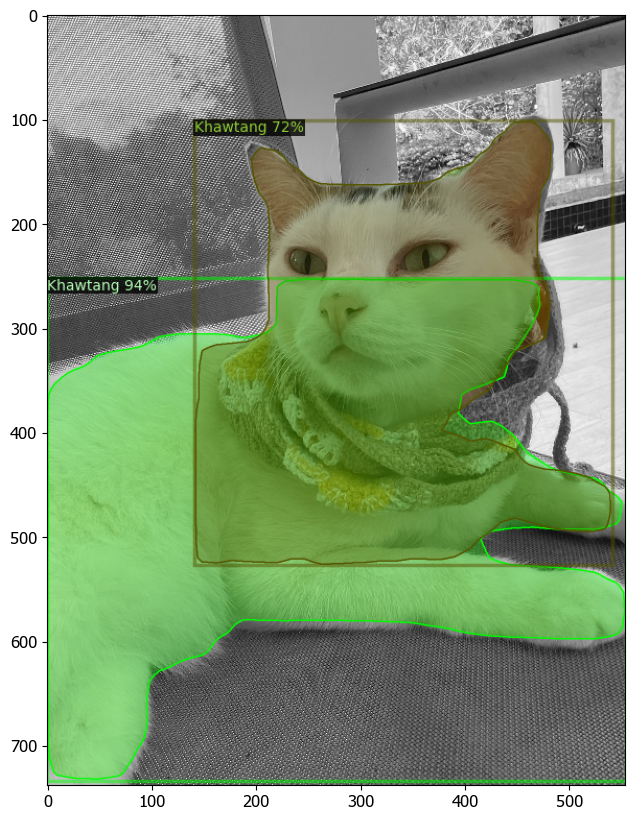

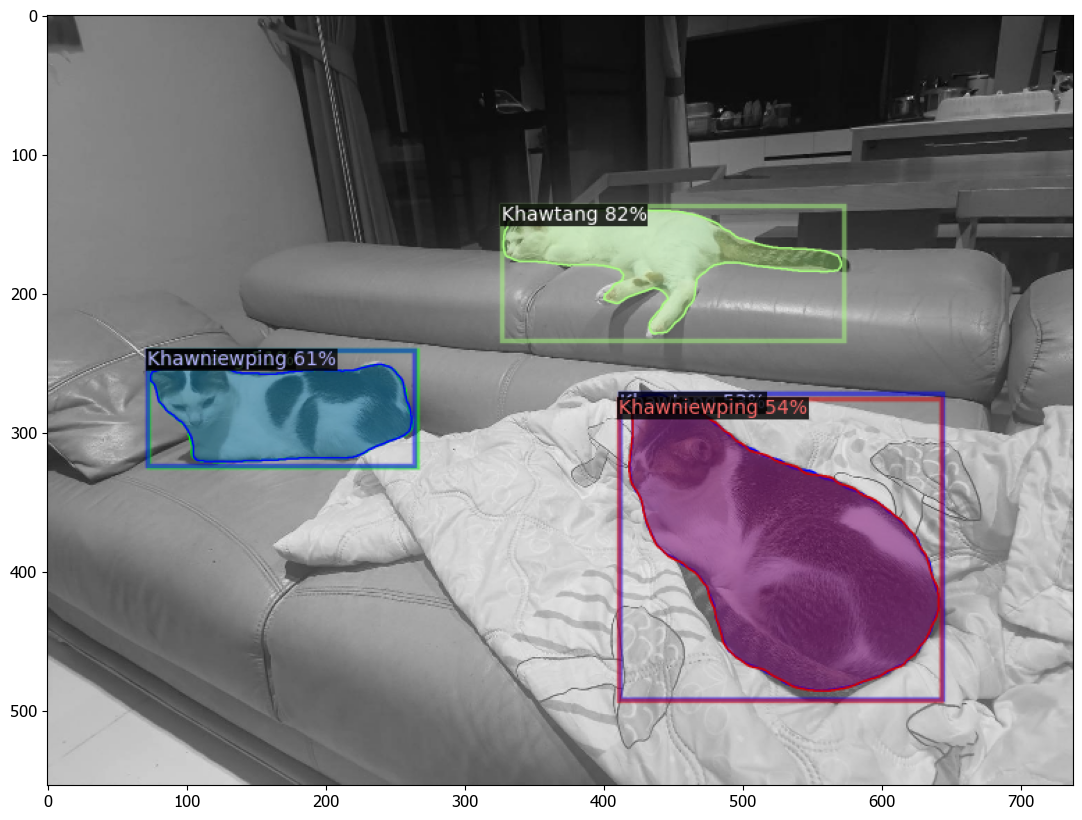

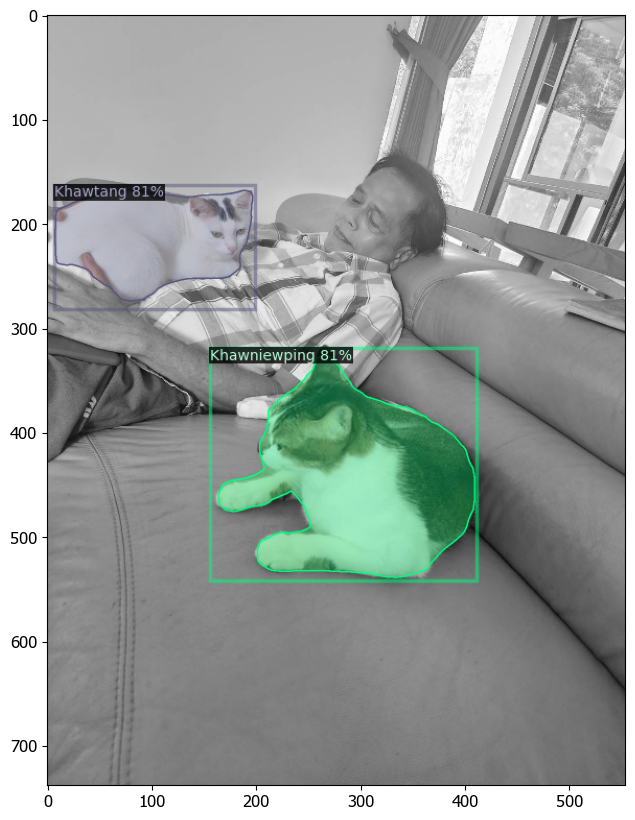

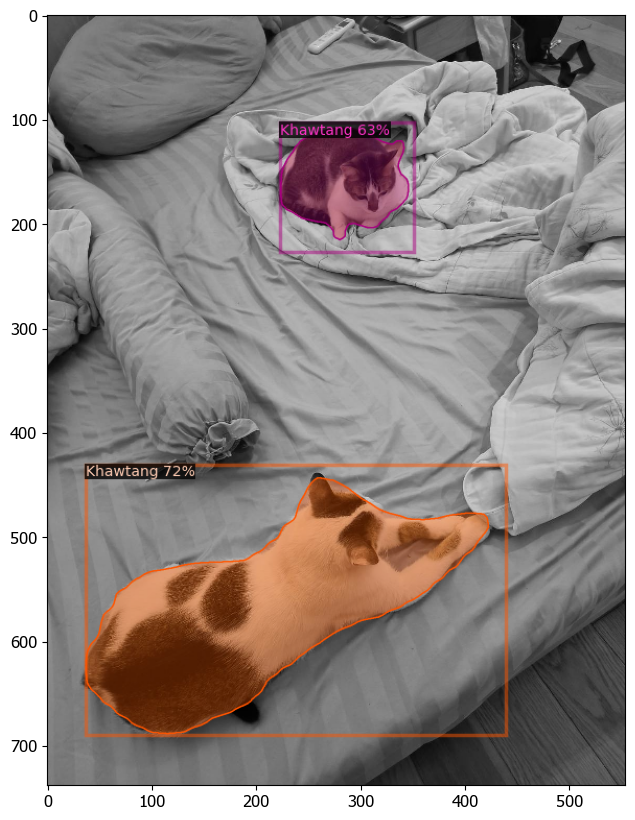

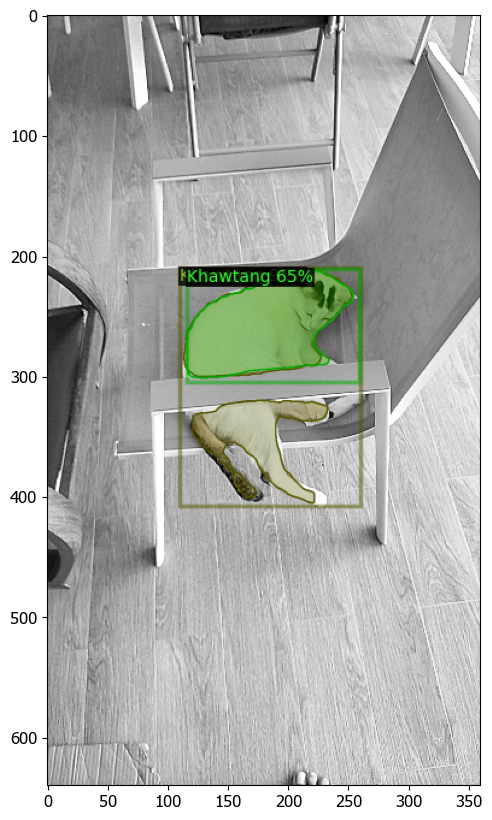

In [17]:
index = 0
for d in top_3_images:
    im = cv2.imread(f"cat-dataset/test/{d}")
    output = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=cat_metadata,
        scale=0.5,
        instance_mode=ColorMode.IMAGE_BW,
    )
    out = v.draw_instance_predictions(output["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()